# Homework Reperimento dell'informazione
## Leonardo Lerose, 1197669

In questo notebook vengono riportati alcuni test e risultati relativi alle run richieste dalla consegna.
In particolare si fa riferimento ai risultati riportati in output dal comando `trec_eval` di terrier elaborando il file di query relevance dato.
Le run da analizzare sono le seguenti:
- **run #1**: Utilizzo di stop list e porter stemmer, con modello BM25
- **run #2**: Utilizzo di stop list e porter stemmer, con modello TF*IDF
- **run #3**: Utilizzo di porter stemmer, con modello BM25
- **run #4**: Utilizzo modello TF*IDF


# Import e funzioni di supporto 

In [6]:
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

In [7]:
#Ritorna un file parsato, dato un preciso path
def parse_file(path):
    parsedFile = list(csv.reader(open(path), delimiter='\t'))
    for i in range(len(parsedFile)):
        for j in range(len(parsedFile[i])):
            parsedFile[i][j] = re.sub('\s', '', parsedFile[i][j])
    return parsedFile


#ritorna il valore numerico di una coppia parametro-ID(quey)
def parameter_and_ID(inputTextAsList, parameter, queryID):
    for i in range(len(inputTextAsList)):
        if inputTextAsList[i][0] == parameter and inputTextAsList[i][1] == queryID:
            if(len(inputTextAsList[i]) > 2):
                return float(inputTextAsList[i][2])


#ritorna una lista di valori numerici di query in un range particolare (queryRange è una lista di indici)
def parameter_and_ID_range(inputTextAsList, parameter, queryRange):
    parameters = []
    for i in range(len(queryRange)):
        parameters.append(parameter_and_ID(inputTextAsList, parameter, queryRange[i]))
    return parameters

#usato per plottare un grafico che paragona 4 istogrammi
def plot4histograms(title, xLabel, yLabel, vals1, vals2, vals3, vals4, mvals1, mvals2, mvals3, mvals4, y, y_inc, width, l1, l2, l3, l4, ml1, ml2, ml3, ml4, xrange):
    indx = np.arange(len(vals1))
    indy = np.arange(0, y, y_inc)
    
    fig,ax = plt.subplots()
    fig_size = plt.rcParams['figure.figsize']
    fig_size[0] = 20
    fig_size[1] = 20
    plt.rcParams['figure.figsize'] = fig_size
    
    rects1 = ax.bar(indx -3*(width/2), vals1, width, 
                color='ForestGreen', label=l1)
    rects2 = ax.bar(indx -width/2, vals2, width, 
                color='SkyBlue', label=l2)
    rects3 = ax.bar(indx + width/2, vals3, width, 
                color='IndianRed', label=l3)
    rects4 = ax.bar(indx +3*(width/2), vals4, width, 
                color='DarkOrange', label=l4)
    
    mline1 = np.full(len(vals1), mvals1)
    mline2 = np.full(len(vals2), mvals2)
    mline3 = np.full(len(vals3), mvals3)
    mline4 = np.full(len(vals4), mvals4)
    ax.plot(mline1, color='ForestGreen', label=ml1)
    ax.plot(mline2, color='SkyBlue', label=ml2)
    ax.plot(mline3, color='IndianRed', label=ml3)
    ax.plot(mline4, color='DarkOrange', label=ml4)
    
    ax.set_xlabel(xLabel)
    ax.set_ylabel(yLabel)
    ax.set_title(title)
    ax.set_xticks(indx)
    ax.set_yticks(indy)
    ax.set_xticklabels(xrange)
    
    ax.legend()
    #plt.savefig(title + "4hists.png" )
    plt.show()

#metodo per eseguire il test Anova one way
def anova(col1, col2, col3, col4):
    
    N = len(col1) + len(col2) + len(col3) + len(col4)
    n = len(col1)
    k = 4
    
    col1 = np.asarray(col1)
    col2 = np.asarray(col2)
    col3 = np.asarray(col3)
    col4 = np.asarray(col4)

    mean_sq = (np.sum(col1) + np.sum(col2) + np.sum(col3) + np.sum(col4))**2 / N

    SSTotal = (np.sum(col1**2) + np.sum(col2**2) + np.sum(col3**2) + np.sum(col4**2)) - mean_sq

    SSTreatment = (sum(col1)**2/n + sum(col2)**2/n + sum(col3)**2/n + sum(col4)**2/n) - mean_sq

    SSError = SSTotal - SSTreatment

    MSTreatment = SSTreatment / (k - 1)
    MSError = SSError / (N - k)


    f_ratio = MSTreatment / MSError

    p_value = stats.f.sf(f_ratio, k-1, N-k)
    
    print("Tabella Anova: ")
    print()
    print("\t Sistema \t Errore")
    print("SS:\t", '%.6f'%(SSTreatment), "\t", '%.6f'%(SSError))
    print("df:\t", k-1, "\t\t", N-k,)
    print("MS:\t", '%.6f'%(MSTreatment), "\t", '%.6f'%(MSError))
    print("f-ratio:", '%.6f'%(f_ratio))
    print("p-value:", '%.6f'%(p_value))
    print()


#metodo per eseguire il test di tukey e determinare quali sono gli elementi del top group
def tukey(col1, label1, col2, label2, col3, label3, col4, label4, compValue):
    conc_all = np.concatenate([col1, col2, col3, col4])
    
    conc_lab1 = [label1 for i in range(len(col1))]
    conc_lab2 = [label2 for i in range(len(col2))]
    conc_lab3 = [label3 for i in range(len(col3))]
    conc_lab4 = [label4 for i in range(len(col4))]
    conc_allLab = np.concatenate((conc_lab1, conc_lab2, conc_lab3, conc_lab4))
    mc = MultiComparison(conc_all.astype('float'), conc_allLab)
    result = mc.tukeyhsd()
    
    #calcola la colonna con la media migliore per determinare la run che identifica il top group
    r1 = (label1, np.sum(col1)/len(col1))
    r2 = (label2, np.sum(col2)/len(col2))
    r3 = (label3, np.sum(col3)/len(col3))
    r4 = (label4,np.sum(col4)/len(col4))
    values = [r1, r2, r3, r4]
    best = values[0]
    for i in range(len(values)):
        if values[i][1] >= best[1]:
            best = values[i]
    bestvaluelabel = best[0]

    print(result)
    result.plot_simultaneous(comparison_name=bestvaluelabel, xlabel=compValue,ylabel="RUN")


# Dati

Per quanto riguarda la nomenclatura data alle variabili nel codice, è stato utilizzato un nome il più descrittivo possibile. In particolare l'identificativo viene creato considerando il modello (`BM25` o `TFIDF`), la presenza di stop list e porter stemmer (`SL` e/o `PS`), la measure in considerazione (`AP`, `Rprec` ...) e la differenza tra dato medio cumulativo oppure array di dati per considerare i 50 topic (`50` alla fine del nome della variabile) 



In [8]:
#path dei file che contengono i risultati della valutazione
stopListPorterStemmer_BM25path = 'res_val/run1.txt'
stopListPorterStemmer_TFIDFpath = 'res_val/run2.txt'
porterStemmer_BM25path = 'res_val/run3.txt'
TFIDFpath = 'res_val/run4.txt'

#risultato del parsing
pFile_SL_PS_BM25 = parse_file(stopListPorterStemmer_BM25path)
pFile_SL_PS_TFIDF = parse_file(stopListPorterStemmer_TFIDFpath)
pFile_PS_BM25 = parse_file(porterStemmer_BM25path)
pFile_TFIDF = parse_file(TFIDFpath)

#creazione di una lista di indici(da 351 a 400)
qrange_351_400 = []
for x in range(351, 401):
    qrange_351_400.append(str(x))

#risultati run BM25 con stop-list e porter stemmer
ap_SL_PS_BM2550 = parameter_and_ID_range(pFile_SL_PS_BM25, 'map', qrange_351_400)
map_SL_PS_BM25 = parameter_and_ID(pFile_SL_PS_BM25, 'map', 'all')
Rprec_SL_PS_BM2550 = parameter_and_ID_range(pFile_SL_PS_BM25, 'Rprec', qrange_351_400)
Rprec_SL_PS_BM25 = parameter_and_ID(pFile_SL_PS_BM25, 'Rprec', 'all')
P10_SL_PS_BM2550 = parameter_and_ID_range(pFile_SL_PS_BM25, 'P_10', qrange_351_400)
P10_SL_PS_BM25 = parameter_and_ID(pFile_SL_PS_BM25, 'P_10', 'all')

PR_SL_PS_BM25 = [parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_0.00', 'all'),
                 parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_0.10', 'all'),
                 parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_0.20', 'all'),
                 parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_0.30', 'all'),
                 parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_0.40', 'all'),
                 parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_0.50', 'all'),
                 parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_0.60', 'all'),
                 parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_0.70', 'all'),
                 parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_0.80', 'all'),
                 parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_0.90', 'all'),
                 parameter_and_ID(pFile_SL_PS_BM25, 'iprec_at_recall_1.00', 'all')]

#risultati run TF_IDF con stop-list e porter stemmer
ap_SL_PS_TFIDF50 = parameter_and_ID_range(pFile_SL_PS_TFIDF, 'map', qrange_351_400)
map_SL_PS_TFIDF = parameter_and_ID(pFile_SL_PS_TFIDF, 'map' , 'all')
Rprec_SL_PS_TFIDF50 = parameter_and_ID_range(pFile_SL_PS_TFIDF, 'Rprec', qrange_351_400)
Rprec_SL_PS_TFIDF = parameter_and_ID(pFile_SL_PS_TFIDF, 'Rprec', 'all')
P10_SL_PS_TFIDF50 = parameter_and_ID_range(pFile_SL_PS_TFIDF, 'P_10', qrange_351_400)
P10_SL_PS_TFIDF = parameter_and_ID(pFile_SL_PS_TFIDF, 'P_10', 'all')

PR_SL_PS_TFIDF = [parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_0.00', 'all'),
                  parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_0.10', 'all'),
                  parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_0.20', 'all'),
                  parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_0.30', 'all'),
                  parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_0.40', 'all'),
                  parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_0.50', 'all'),
                  parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_0.60', 'all'),
                  parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_0.70', 'all'),
                  parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_0.80', 'all'),
                  parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_0.90', 'all'),
                  parameter_and_ID(pFile_SL_PS_TFIDF, 'iprec_at_recall_1.00', 'all')]

#risultati run BM25 senza stop-list e con porter stemmer
ap_PS_BM2550 = parameter_and_ID_range(pFile_PS_BM25, 'map', qrange_351_400)
map_PS_BM25 = parameter_and_ID(pFile_PS_BM25, 'map', 'all')
Rprec_PS_BM2550 = parameter_and_ID_range(pFile_PS_BM25, 'Rprec', qrange_351_400)
Rprec_PS_BM25 = parameter_and_ID(pFile_PS_BM25, 'Rprec', 'all')
P10_PS_BM2550 = parameter_and_ID_range(pFile_PS_BM25, 'P_10', qrange_351_400)
P10_PS_BM25 = parameter_and_ID(pFile_PS_BM25, 'P_10', 'all')

PR_PS_BM25 = [parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_0.00', 'all'),
              parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_0.10', 'all'),
              parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_0.20', 'all'),
              parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_0.30', 'all'),
              parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_0.40', 'all'),
              parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_0.50', 'all'),
              parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_0.60', 'all'),
              parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_0.70', 'all'),
              parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_0.80', 'all'),
              parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_0.90', 'all'),
              parameter_and_ID(pFile_PS_BM25, 'iprec_at_recall_1.00', 'all')]

#risultati run TF_IDF senza stop-list e senza porter stemmer
ap_TFIDF50 = parameter_and_ID_range(pFile_TFIDF, 'map', qrange_351_400)
map_TFIDF = parameter_and_ID(pFile_TFIDF, 'map', 'all')
Rprec_TFIDF50 = parameter_and_ID_range(pFile_TFIDF, 'Rprec', qrange_351_400)
Rprec_TFIDF = parameter_and_ID(pFile_TFIDF, 'Rprec', 'all')
P10_TFIDF50 = parameter_and_ID_range(pFile_TFIDF, 'P_10', qrange_351_400)
P10_TFIDF = parameter_and_ID(pFile_TFIDF, 'P_10', 'all')

PR_TFIDF = [parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_0.00', 'all'),
            parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_0.10', 'all'),
            parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_0.20', 'all'),
            parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_0.30', 'all'),
            parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_0.40', 'all'),
            parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_0.50', 'all'),
            parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_0.60', 'all'),
            parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_0.70', 'all'),
            parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_0.80', 'all'),
            parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_0.90', 'all'),
            parameter_and_ID(pFile_TFIDF, 'iprec_at_recall_1.00', 'all')]



# ANOVA one-way e Tukey-HSD

Vengono riportati di seguito i risultati relativi all'hypothesis testing.

<<< ANOVA ONE-WAY e TUKEY-HSD su measure AP >>>

Tabella Anova: 

	 Sistema 	 Errore
SS:	 0.022283 	 5.395391
df:	 3 		 196
MS:	 0.007428 	 0.027528
f-ratio: 0.269822
p-value: 0.847108

  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      group2   meandiff  lower  upper  reject
------------------------------------------------------
  PS_BM25    SL_PS_BM25  0.0018  -0.0842 0.0877 False 
  PS_BM25   SL_PS_TFIDF  0.0012  -0.0848 0.0872 False 
  PS_BM25      TFIDF    -0.0233  -0.1093 0.0626 False 
 SL_PS_BM25 SL_PS_TFIDF -0.0005  -0.0865 0.0855 False 
 SL_PS_BM25    TFIDF    -0.0251  -0.1111 0.0609 False 
SL_PS_TFIDF    TFIDF    -0.0246  -0.1106 0.0614 False 
------------------------------------------------------

<<< ANOVA ONE-WAY e TUKEY-HSD su measure Rprec >>>

Tabella Anova: 

	 Sistema 	 Errore
SS:	 0.026352 	 4.907223
df:	 3 		 196
MS:	 0.008784 	 0.025037
f-ratio: 0.350849
p-value: 0.788575

  Multiple Comparison of Means - Tukey HSD,FWER=0.05  
   group1      grou

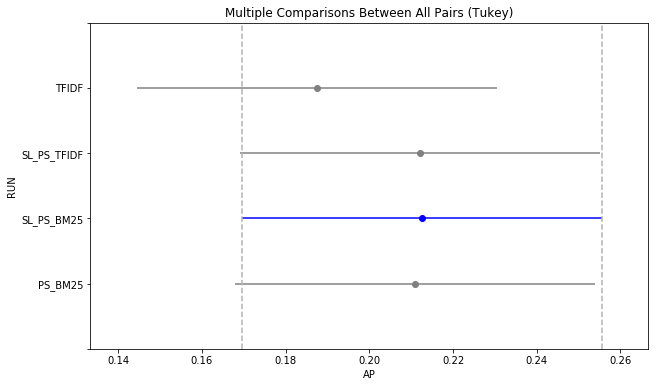

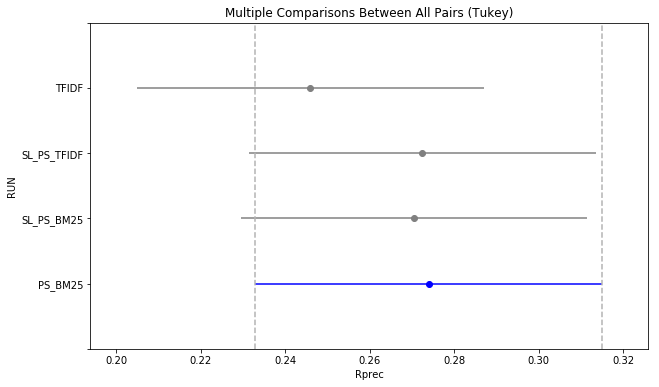

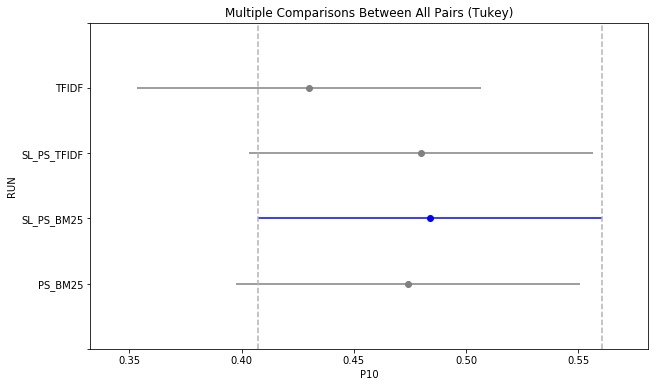

In [9]:
#AP
print("<<< ANOVA ONE-WAY e TUKEY-HSD su measure AP >>>\n")
anova(ap_SL_PS_BM2550, ap_SL_PS_TFIDF50, ap_PS_BM2550, ap_TFIDF50)
tukey(ap_SL_PS_BM2550, 'SL_PS_BM25', ap_SL_PS_TFIDF50, 'SL_PS_TFIDF', ap_PS_BM2550, 'PS_BM25', ap_TFIDF50, 'TFIDF', 'AP')
print()
#RPREC
print("<<< ANOVA ONE-WAY e TUKEY-HSD su measure Rprec >>>\n")
anova(Rprec_SL_PS_BM2550, Rprec_SL_PS_TFIDF50, Rprec_PS_BM2550, Rprec_TFIDF50)
tukey(Rprec_SL_PS_BM2550, 'SL_PS_BM25', Rprec_SL_PS_TFIDF50, 'SL_PS_TFIDF', Rprec_PS_BM2550, 'PS_BM25', Rprec_TFIDF50, 'TFIDF', 'Rprec')
print()
#P@10
print("<<< ANOVA ONE-WAY e TUKEY-HSD su measure P@10 >>>\n")
anova(P10_SL_PS_BM2550, P10_SL_PS_TFIDF50, P10_PS_BM2550, P10_TFIDF50)
tukey(P10_SL_PS_BM2550, 'SL_PS_BM25', P10_SL_PS_TFIDF50, 'SL_PS_TFIDF', P10_PS_BM2550, 'PS_BM25', P10_TFIDF50, 'TFIDF', 'P10')


Dai test Anova, si può notare che i p-value ottenuti sono maggiori di $\alpha$ = 0.05, quindi si "fallisce nel rigettare" la null hypothesis e di conseguenza le run derivano da una distribuzione unica.

Questo è ulteriormente evidenziato dal test di Tukey, infatti osservando i plot per le varie measures, si può notare come tutte le run appartengano al "top group".


# Alcuni risultati grafici

## Average Precision

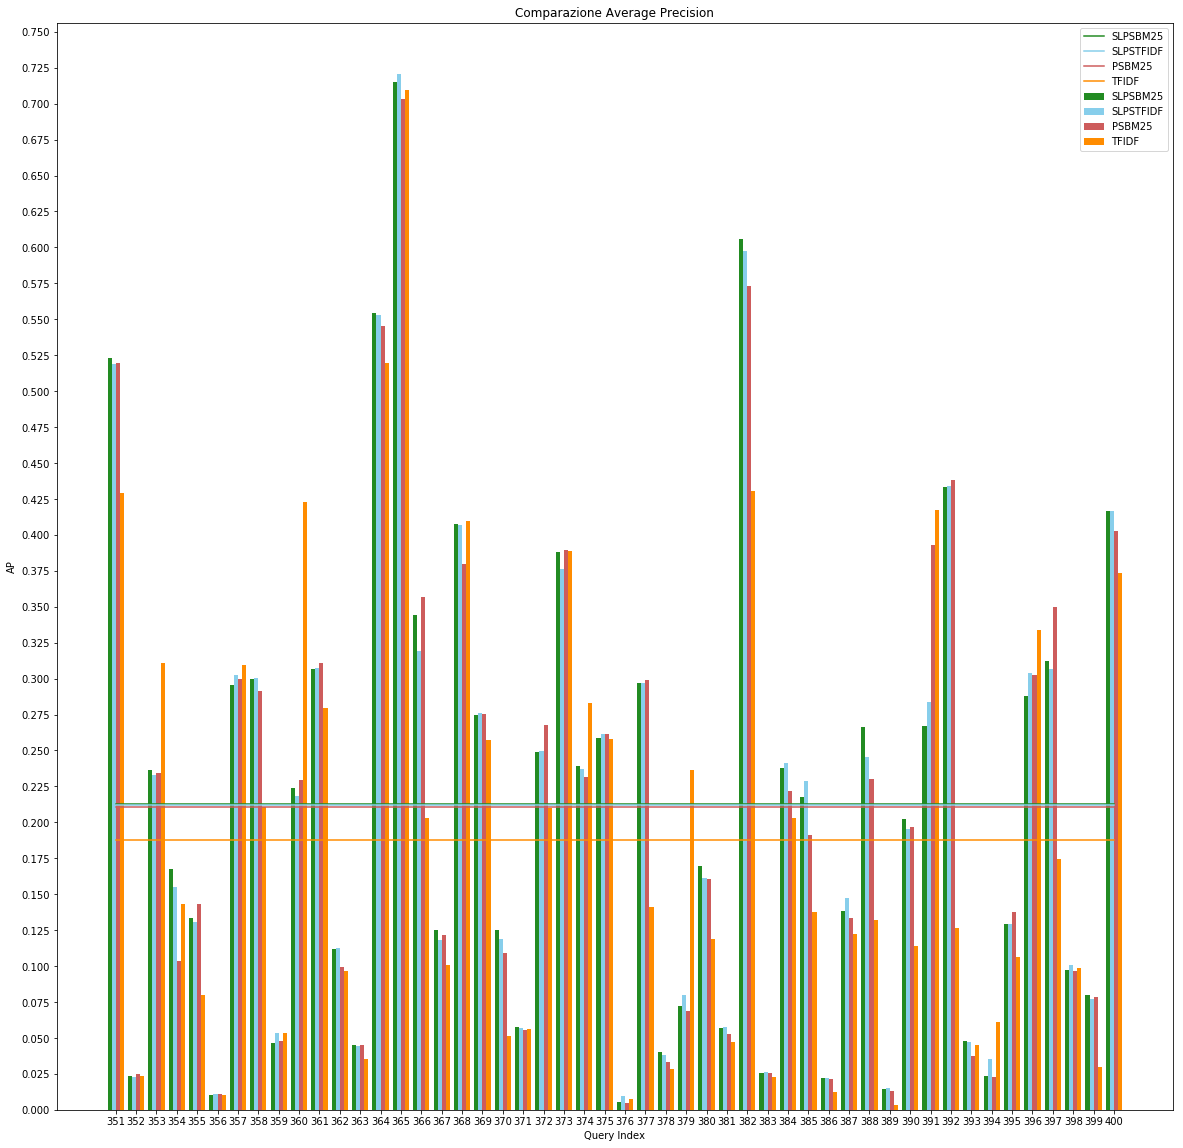

valore di MAP per run BM25 con Stop-List e Porter Stemmer (linea orizzontale verde): 0.2126
valore di MAP per run TFIDF con Stop-List e Porter Stemmer (linea orizzontale azzurra): 0.212
valore di MAP per run BM25 con Porter Stemmer (linea orizzontale rossa): 0.2108
valore di MAP per run TFIDF (linea orizzontale arancione): 0.1875


In [11]:
plot4histograms('Comparazione Average Precision', 'Query Index', 'AP', ap_SL_PS_BM2550, ap_SL_PS_TFIDF50, ap_PS_BM2550, ap_TFIDF50,
                map_SL_PS_BM25, map_SL_PS_TFIDF, map_PS_BM25, map_TFIDF, 0.775, 0.025, 0.20,
                'SLPSBM25', 'SLPSTFIDF','PSBM25','TFIDF', 'SLPSBM25', 'SLPSTFIDF','PSBM25','TFIDF', qrange_351_400)

print("valore di MAP per run BM25 con Stop-List e Porter Stemmer (linea orizzontale verde): " + str(map_SL_PS_BM25))
print("valore di MAP per run TFIDF con Stop-List e Porter Stemmer (linea orizzontale azzurra): " + str(map_SL_PS_TFIDF))
print("valore di MAP per run BM25 con Porter Stemmer (linea orizzontale rossa): " + str(map_PS_BM25))
print("valore di MAP per run TFIDF (linea orizzontale arancione): " + str(map_TFIDF))

Le linee orizzontali rappresentano le MAP per le quattro run diverse. Nel grafico a barre invece vengono rappresentati i valori di AP per ogni topic. Si può notare come la run#4 abbia delle prestazioni inferiori.

## R-Precision

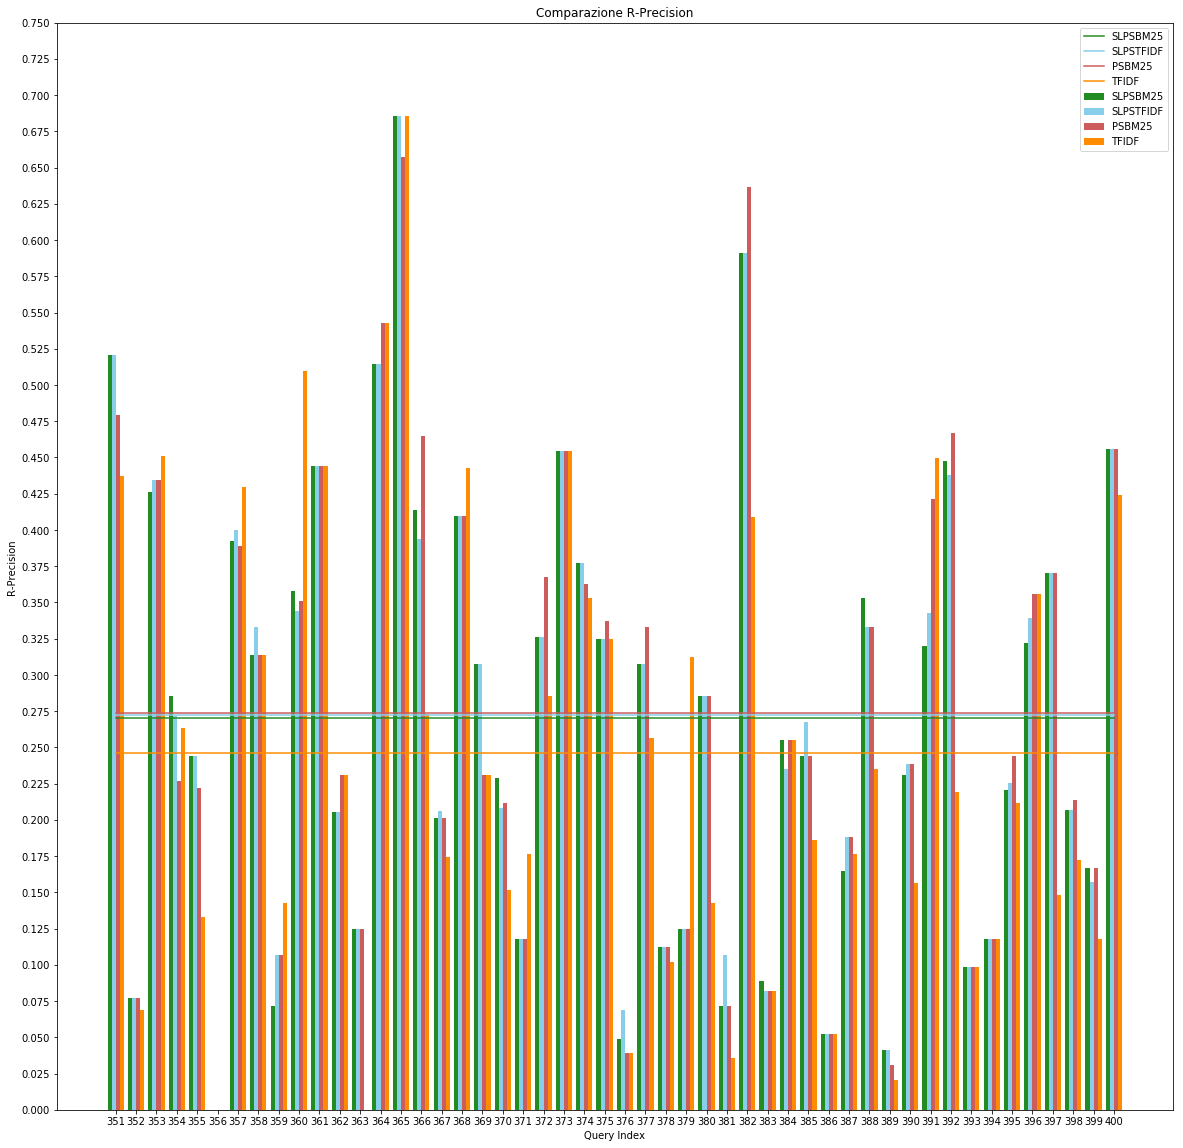

valore di R-Precision medio per run BM25 con Stop-List e Porter Stemmer (linea orizzontale verde): 0.2705
valore di R-Precision medio per run TFIDF con Stop-List e Porter Stemmer (linea orizzontale azzurra): 0.2725
valore di R-Precision medio per run BM25 con Porter Stemmer (linea orizzontale rossa): 0.274
valore di R-Precision medio per run TFIDF (linea orizzontale arancione): 0.246


In [12]:
plot4histograms('Comparazione R-Precision', 'Query Index', 'R-Precision', Rprec_SL_PS_BM2550, Rprec_SL_PS_TFIDF50, Rprec_PS_BM2550, Rprec_TFIDF50,
                Rprec_SL_PS_BM25, Rprec_SL_PS_TFIDF, Rprec_PS_BM25, Rprec_TFIDF, 0.775, 0.025, 0.20,
                'SLPSBM25', 'SLPSTFIDF','PSBM25','TFIDF', 'SLPSBM25', 'SLPSTFIDF','PSBM25','TFIDF', qrange_351_400)

print("valore di R-Precision medio per run BM25 con Stop-List e Porter Stemmer (linea orizzontale verde): " + str(Rprec_SL_PS_BM25))
print("valore di R-Precision medio per run TFIDF con Stop-List e Porter Stemmer (linea orizzontale azzurra): " + str(Rprec_SL_PS_TFIDF))
print("valore di R-Precision medio per run BM25 con Porter Stemmer (linea orizzontale rossa): " + str(Rprec_PS_BM25))
print("valore di R-Precision medio per run TFIDF (linea orizzontale arancione): " + str(Rprec_TFIDF))

Le linee orizzontali rappresentano la R-precision media per le quattro run diverse. Nel grafico a barre invece vengono rappresentati i valori di R-precision per ogni topic. Anche qui si può notare come la run#4 abbia delle prestazioni inferiori.

## Precision @ 10

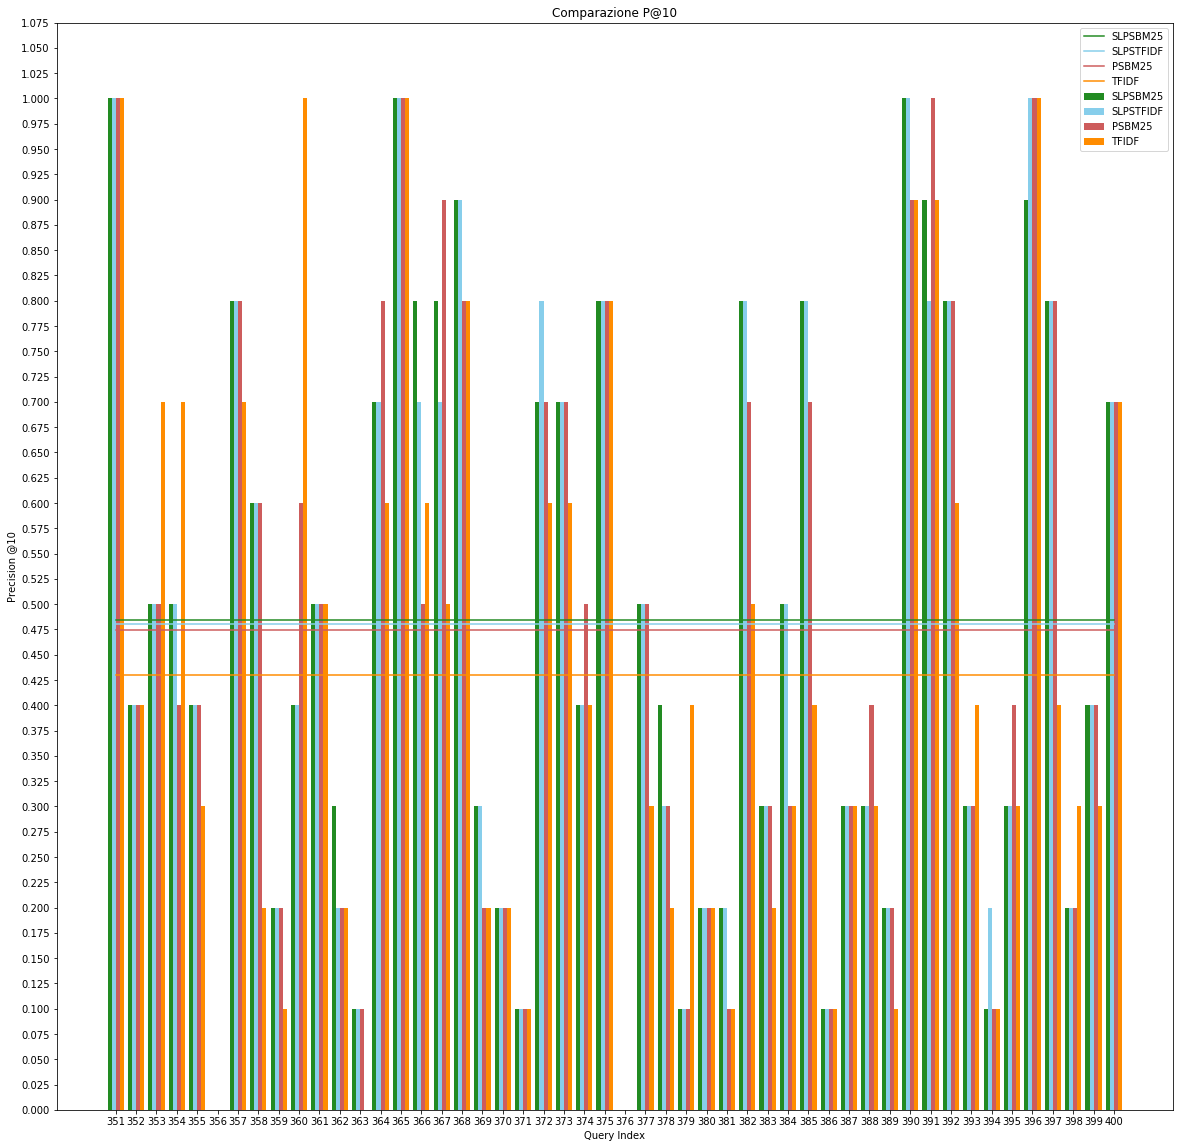

valore di Precision @10 medio per run BM25 con Stop-List e Porter Stemmer (linea orizzontale verde): 0.484
valore di Precision @10 medio per run TFIDF con Stop-List e Porter Stemmer (linea orizzontale azzurra): 0.48
valore di Precision @10 medio per run BM25 con Porter Stemmer (linea orizzontale rossa): 0.474
valore di Precision @10 medio per run TFIDF (linea orizzontale arancione): 0.43


In [13]:
plot4histograms('Comparazione P@10', 'Query Index', 'Precision @10', P10_SL_PS_BM2550, P10_SL_PS_TFIDF50, P10_PS_BM2550, P10_TFIDF50,
                P10_SL_PS_BM25, P10_SL_PS_TFIDF, P10_PS_BM25, P10_TFIDF, 1.1, 0.025, 0.20,
                'SLPSBM25', 'SLPSTFIDF','PSBM25','TFIDF', 'SLPSBM25', 'SLPSTFIDF','PSBM25','TFIDF',qrange_351_400)

print("valore di Precision @10 medio per run BM25 con Stop-List e Porter Stemmer (linea orizzontale verde): " + str(P10_SL_PS_BM25))
print("valore di Precision @10 medio per run TFIDF con Stop-List e Porter Stemmer (linea orizzontale azzurra): " + str(P10_SL_PS_TFIDF))
print("valore di Precision @10 medio per run BM25 con Porter Stemmer (linea orizzontale rossa): " + str(P10_PS_BM25))
print("valore di Precision @10 medio per run TFIDF (linea orizzontale arancione): " + str(P10_TFIDF))

Le linee orizzontali rappresentano la Precision@10 media per le quattro run diverse. Nel grafico a barre invece vengono rappresentati i valori di Precision@10 per ogni topic. Anche qui si può notare come la run#4 abbia delle prestazioni inferiori.

## Grafico Interpolated Precision Recall
Viene di seguito riportato il grafico relativo alla Precision-Recall interpolata, che compara le 4 diverse run.

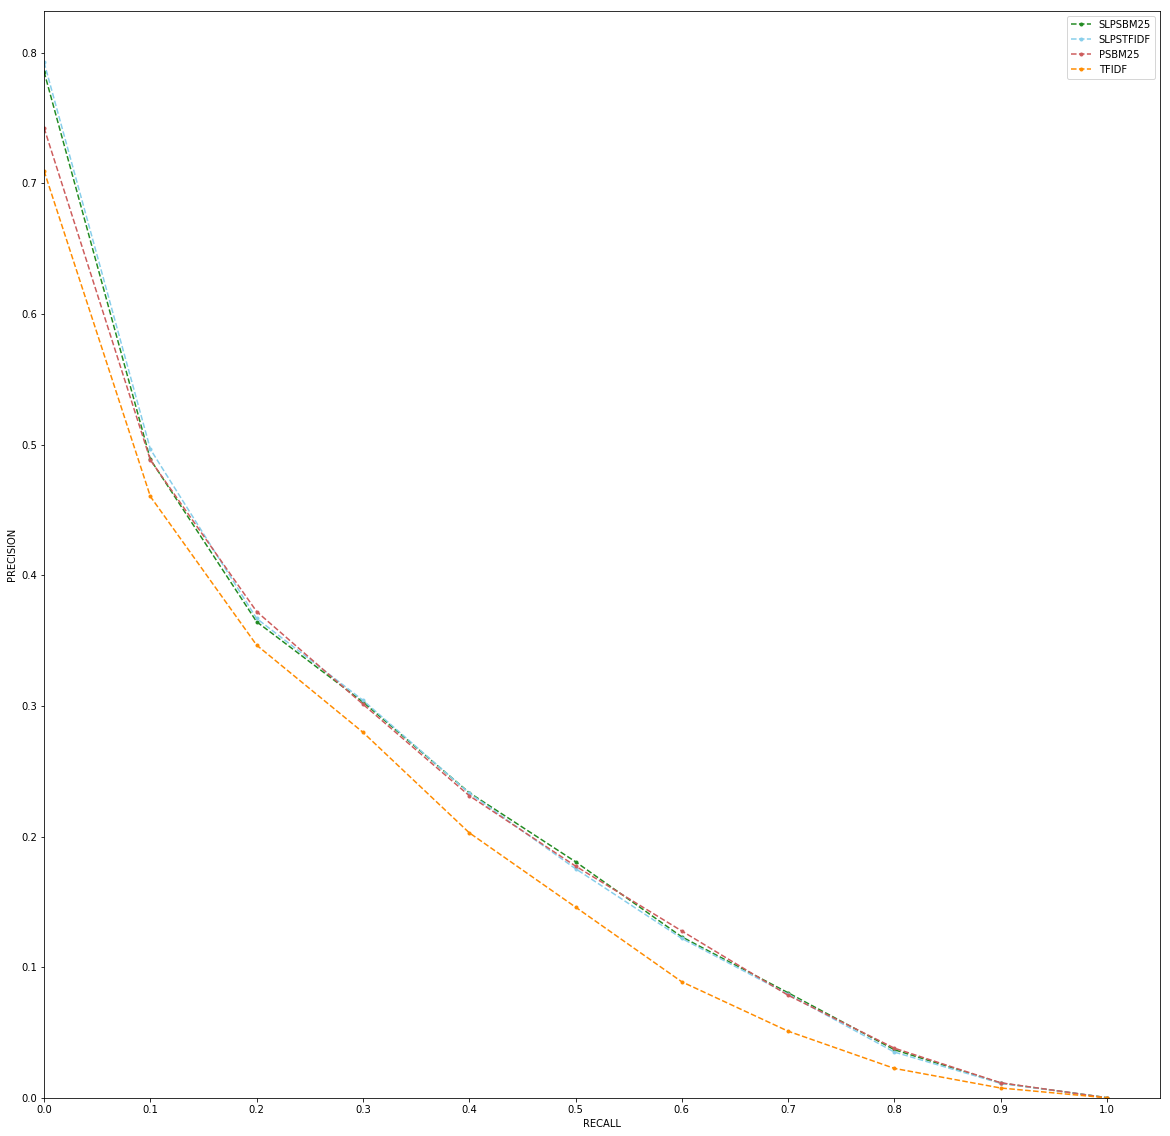

In [15]:
precision = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
plt.plot(precision, PR_SL_PS_BM25, marker='.', ls='--', color= 'ForestGreen', label='SLPSBM25')
plt.plot(precision, PR_SL_PS_TFIDF, marker='.', ls='--', color= 'SkyBlue', label='SLPSTFIDF')
plt.plot(precision, PR_PS_BM25, marker='.', ls='--', color= 'IndianRed', label='PSBM25')
plt.plot(precision, PR_TFIDF, marker='.', ls='--', color= 'DarkOrange', label='TFIDF')
plt.xlabel("RECALL")
plt.ylabel("PRECISION")
plt.xlim(xmin=0)
plt.ylim(ymin=0)
plt.xticks(precision)
plt.legend()
#plt.savefig('IPrecisionRecall.png')
plt.show()


Dal grafico della interpolated Precision Recall, possiamo notare che le prestazioni della run #4 TF*IDF risultano lievemente peggiori, concordemente ai risultati evidenziati precedentemente.